# KTS algorithm pulled from https://github.com/li-plus/DSNet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Declaration of KTS functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

In [4]:
def calc_scatters(K):
    """Calculate scatter matrix: scatters[i,j] = {scatter of the sequence with
    starting frame i and ending frame j}
    """
    n = K.shape[0]
    K1 = np.cumsum([0] + list(np.diag(K)))
    K2 = np.zeros((n + 1, n + 1))
    K2[1:, 1:] = np.cumsum(np.cumsum(K, 0), 1)

    diagK2 = np.diag(K2)

    i = np.arange(n).reshape((-1, 1))
    j = np.arange(n).reshape((1, -1))
    scatters = (
            K1[1:].reshape((1, -1)) - K1[:-1].reshape((-1, 1)) -
            (diagK2[1:].reshape((1, -1)) + diagK2[:-1].reshape((-1, 1)) -
             K2[1:, :-1].T - K2[:-1, 1:]) /
            ((j - i + 1).astype(np.float32) + (j == i - 1).astype(np.float32))
    )
    scatters[j < i] = 0

    return scatters


def cpd_nonlin(K, ncp, lmin=1, lmax=100000, backtrack=True, verbose=True,
               out_scatters=None):
    """Change point detection with dynamic programming

    :param K: Square kernel matrix
    :param ncp: Number of change points to detect (ncp >= 0)
    :param lmin: Minimal length of a segment
    :param lmax: Maximal length of a segment
    :param backtrack: If False - only evaluate objective scores (to save memory)
    :param verbose: If true, print verbose message
    :param out_scatters: Output scatters
    :return: Tuple (cps, obj_vals)
        - cps - detected array of change points: mean is thought to be constant
            on [ cps[i], cps[i+1] )
        - obj_vals - values of the objective function for 0..m changepoints
    """
    m = int(ncp)  # prevent numpy.int64

    n, n1 = K.shape
    assert n == n1, 'Kernel matrix awaited.'
    assert (m + 1) * lmin <= n <= (m + 1) * lmax
    assert 1 <= lmin <= lmax

    if verbose:
        print('Precomputing scatters...')
    J = calc_scatters(K)

    if out_scatters is not None:
        out_scatters[0] = J

    if verbose:
        print('Inferring best change points...')
    # I[k, l] - value of the objective for k change-points and l first frames
    I = 1e101 * np.ones((m + 1, n + 1))
    I[0, lmin:lmax] = J[0, lmin - 1:lmax - 1]

    if backtrack:
        # p[k, l] --- 'previous change' --- best t[k] when t[k+1] equals l
        p = np.zeros((m + 1, n + 1), dtype=int)
    else:
        p = np.zeros((1, 1), dtype=int)

    for k in range(1, m + 1):
        for l in range((k + 1) * lmin, n + 1):
            tmin = max(k * lmin, l - lmax)
            tmax = l - lmin + 1
            c = J[tmin:tmax, l - 1].reshape(-1) + \
                I[k - 1, tmin:tmax].reshape(-1)
            I[k, l] = np.min(c)
            if backtrack:
                p[k, l] = np.argmin(c) + tmin

    # Collect change points
    cps = np.zeros(m, dtype=int)

    if backtrack:
        cur = n
        for k in range(m, 0, -1):
            cps[k - 1] = p[k, cur]
            cur = cps[k - 1]

    scores = I[:, n].copy()
    scores[scores > 1e99] = np.inf
    return cps, scores


def cpd_auto(K, ncp, vmax, desc_rate=1, **kwargs):
    """Detect change points automatically selecting their number

    :param K: Kernel between each pair of frames in video
    :param ncp: Maximum number of change points
    :param vmax: Special parameter
    :param desc_rate: Rate of descriptor sampling, vmax always corresponds to 1x
    :param kwargs: Extra parameters for ``cpd_nonlin``
    :return: Tuple (cps, costs)
        - cps - best selected change-points
        - costs - costs for 0,1,2,...,m change-points
    """
    m = ncp
    _, scores = cpd_nonlin(K, m, backtrack=False, **kwargs)

    N = K.shape[0]
    N2 = N * desc_rate  # length of the video before down-sampling

    penalties = np.zeros(m + 1)
    # Prevent division by zero (in case of 0 changes)
    ncp = np.arange(1, m + 1)
    penalties[1:] = (vmax * ncp / (2.0 * N2)) * (np.log(float(N2) / ncp) + 1)

    costs = scores / float(N) + penalties
    m_best = np.argmin(costs)
    cps, scores2 = cpd_nonlin(K, m_best, **kwargs)

    return cps, scores2

# Prepare the Resnet

In [5]:
# Install and import necessary packages
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

from transformers import DetrImageProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


In [6]:
resnet_loc = "/content/drive/MyDrive/EECS545 Group/Architecture Components/Resnet 101.bin"
processor_loc = "/content/drive/MyDrive/EECS545 Group/Architecture Components/preprocessor_config.json"

resnet = torch.load("/content/drive/MyDrive/EECS545 Group/Architecture Components/Resnet 101.bin", map_location=device)
preprocessor = DetrImageProcessor.from_json_file("/content/drive/MyDrive/EECS545 Group/Architecture Components/preprocessor_config.json")

# Declaration of custom functions for KTS

In [11]:
'''
Calculate the Kernel matrix using Resnet for the images in
Input:
    folder: the path to folder holding the images
Output:
    K: the kernel matrix containing pairwise similarity score
'''
def calculate_K(folder):
    images = []

    # Sort the image names
    items = os.listdir(folder)
    items.sort(key=lambda x: int(x.split('.')[0]))

    # Read the images
    for item in items:
        image = np.array(Image.open(os.path.join(folder, item)))
        images.append(image)

    # Compute the K matrix, pair-wise similarity scoring with dot product
    n = len(images)
    K = np.zeros((n, n))

    for i in range(n):
        # Run image through Resnet to compute the feature
        inputs = preprocessor(images=[images[i]], return_tensors="pt").to(device)
        features_i = resnet(**inputs)[0][-1][0]

        for j in range(i, n):
            # Run image through Resnet to compute the feature
            inputs = preprocessor(images=[images[j]], return_tensors="pt").to(device)
            features_j = resnet(**inputs)[0][-1][0]

            # Compute the dot product of the features
            dot_product = torch.sum(features_i * features_j).to(torch.device("cpu")).numpy()
            K[i, j] = dot_product
            K[j, i] = dot_product

    return K

'''
Select the important frames to include in the final short video, based on
segment-level importance.
Input:
    K: the kernel matrix with pairwise similarity score
    importance: the frame-level score predicted from modified XClip model
    max_video_length: the maximum length of video in seconds
Output:
    frame_decision: the frame-level decision on whether this frame will be kept
'''
def select_frames(K, importance, max_video_length=120):
    n = K.shape[0]

    # Use KTS to find the break points for video segments
    cps, _ = cpd_nonlin(K, 30, lmin=4) # Can play with parameters, currently generate 30 segments each with at least 4 frames
    print("Current change points:", cps, f"Total: {len(cps)}")

    # Based on the importance score from modified XClip, compute importance score for each segment by average
    cps = np.append(np.insert(cps, 0, 0), n)
    segment_importance = np.zeros(len(cps)-1)

    for i in range(len(segment_importance)):
        segment_importance[i] = np.mean(importance[cps[i]:cps[i+1]])

    # Select the top segments to make a video with total length shorter than specified
    max_frames_alloed = max_video_length * 2 # Since each down-sampled frame was at 2 / second
    segment_importance_order = np.argsort(segment_importance)[::-1]

    current_frames = 0
    current_index = 0
    frame_decision = np.zeros(n)
    while True:
        # If adding the next segment does not exceed the max length, add it
        segment_index = segment_importance_order[current_index]
        if current_frames + (cps[segment_index+1] - cps[segment_index]) <= max_frames_alloed:
            frame_decision[cps[segment_index]:cps[segment_index+1]] = 1
            current_frames += (cps[segment_index+1] - cps[segment_index])
            current_index += 1

        # Otherwise we are done
        else:
            break

    return frame_decision

def make_video(video_source, video_dest, frame_decision):
    # Prepare the video reader and video writer
    source = cv2.VideoCapture(video_source)
    fps = int(source.get(cv2.CAP_PROP_FPS))
    width = int(source.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(source.get(cv2.CAP_PROP_FRAME_HEIGHT))

    dest = cv2.VideoWriter(video_dest, fourcc=cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), fps=fps, frameSize=(width, height))

    # Based on frame assignment, selectively write frames
    for i in range(n):
        # Each frame to keep corresponds to fps // 2 frames in the original video
        if frame_decision[i]:
            for _ in range(fps // 2):
                ret,frame = source.read()

                if ret:
                    dest.write(frame)
                else:
                    break

    # Release all space and windows once done
    source.release()
    dest.release()
    cv2.destroyAllWindows()
    print(f"Finished processing {video_source.split('/')[-1]}")

In [ ]:
# Demonstration run with training video
folder = "/content/drive/MyDrive/EECS545 Group/Dataset/TVSum/down-sampled frames/train/-esJrBWj2d8"
importance = np.random.randint(low=1, high=6, size=len(os.listdir(folder)))
video_source = "/content/drive/MyDrive/EECS545 Group/Dataset/TVSum/video/-esJrBWj2d8.mp4"
video_dest = "/content/drive/MyDrive/EECS545 Group/Dataset/test.mp4"

K = calculate_K(folder)
frame_decision = select_frames(K, importance)
make_video(video_source, video_dest, frame_decision)

# Demonstration of KTS algorithm

In [ ]:
# Data generation function
def gen_data(n, m, d=1):
    """Generates data with change points

    .. warning::
        sigma is proportional to m

    :param n: Number of samples
    :param m: Number of change-points
    :param d:
    :return: Tuple (X, cps)
        - X - data array (n X d)
        - cps - change-points array, including 0 and n
    """
    np.random.seed(1)
    # Select changes at some distance from the boundaries
    cps = np.random.permutation(n * 3 // 4 - 1)[0:m] + 1 + n // 8
    cps = np.sort(cps)
    cps = [0] + list(cps) + [n]
    mus = np.random.rand(m + 1, d) * (m / 2)  # make sigma = m/2
    X = np.zeros((n, d))
    for k in range(m + 1):
        X[cps[k]:cps[k + 1], :] = mus[k, :][np.newaxis, :] + np.random.rand(
            cps[k + 1] - cps[k], d)
    return X, np.array(cps)

Ground truth: [   0  145  186  210  211  216  315  342  388  399  500  540  598  661
  675  704  744  750  789  792  811 1000] 
Total:  22
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
Estimated: [145 186 210 211 216 315 342 388 399 500 540 598 661 675 704 744 750 789
 792 811] 
Total:  20


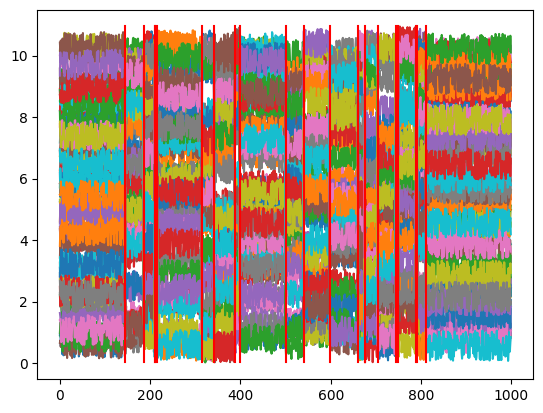

In [ ]:
# Demonstration of auto segmentation on data with 20 pre-defined breakpoints
plt.figure('Test: multidimensional signal')

n = 1000
m = 20
(X, cps_gt) = gen_data(n, m, d=50)
print('Ground truth:', cps_gt, "\nTotal: ", len(cps_gt))

plt.plot(X)

K = np.dot(X, X.T)
cps, scores = cpd_auto(K, 3*m, 10)
print('Estimated:', cps, "\nTotal: ", len(cps))

mi = np.min(X)
ma = np.max(X)
for cp in cps:
    plt.plot([cp, cp], [mi, ma], 'r')
plt.show()